In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from pathlib import Path
import pickle
from scipy.io import loadmat
import seaborn as sns

import jaxley as jx
from jaxley_retina.OPL.PR import build_PR
from jaxley_retina.OPL.transforms import PTC_transform as transform

In [2]:
# Build the photoreceptor
PR, params_mouse_cone = build_PR()

In [3]:
# Load the stimuli and data
data = loadmat("../../data/RiekeMouseConeResponses.mat")

responses = [data['ConeResponses'][0][i][0][0][0][0] for i in range(6)]
stimuli = [data['ConeResponses'][0][i][0][0][1][0] for i in range(6)]

In [4]:
# Set up the recordings
PR.delete_recordings()
PR.record("PR_Phototransduction_I")

# Set up the parameter training
PR.delete_trainables()
for name, param in params_mouse_cone.items():
    PR.make_trainable(name, param)
init_params = PR.get_parameters()

# Write the simulation and loss functions
def simulate(params, stim):
    data_clamps = PR.data_clamp("PR_Phototransduction_Stim", stim, None)
    soln = jx.integrate(
        PR,
        delta_t=0.025, # limited by the resolution of the stimulus.. could interpolate the stim to reduce the time step if really needed
        data_clamps=data_clamps,
        params=params
    )
    return soln[0]

def loss_fn(params, stim, data):
    soln = simulate(params, stim)
    # Subsample (stim was interpolated)
    soln = soln[::num_interpolated_points]
    # Calculate the dark current and normalize the solution by that
    I_dark = (
        params[9]["PR_Phototransduction_G_dark"]
        ** params[7]["PR_Phototransduction_n"]
        * params[5]["PR_Phototransduction_k"]
    )
    soln = -1 * soln / I_dark  # also sign flip for correct direction
    return jnp.sum((soln-data)**2)

# Number of points to interpolate between each pair of points
num_interpolated_points = int(0.1 / 0.025) # 4

def interp_stim(stim):
    interp = lambda x, y: jnp.linspace(x, y, num=num_interpolated_points)
    interpolated_stim = jax.vmap(interp)(stim[:-1], np.roll(stim, -1)[:-1])
    interpolated_stim = interpolated_stim.flatten()
    return interpolated_stim


Added 1 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Number of newly added trainable parameters: 1. Total number of trainable parameters: 4
Number of newly added trainable parameters: 1. Total number of trainable parameters: 5
Number of newly added trainable parameters: 1. Total number of trainable parameters: 6
Number of newly added trainable parameters: 1. Total number of trainable parameters: 7
Number of newly added trainable parameters: 1. Total number of trainable parameters: 8
Number of newly added trainable parameters: 1. Total number of trainable parameters: 9
Number of newly added trainable parameters: 1. Total number of trainable parameters: 10
Number of newly added trainable parameters: 1. Total number of trainable param

In [5]:
# Cell 1 example
stim = stimuli[0]
data = responses[0]

# Interpolate the stimulus
interpolated_stim = interp_stim(stim)

In [6]:
# Try simulating with the interpolated solution
init_soln = simulate(init_params, interpolated_stim)
init_soln = init_soln[::num_interpolated_points]
time = np.arange(0, 16, 0.0001)

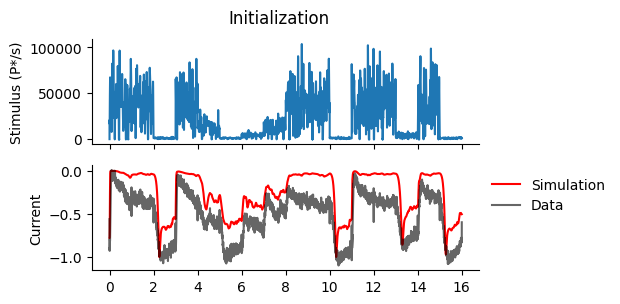

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(5, 3), sharex=True)
axs[0].plot(time, stimuli[0])
axs[1].plot(time, -1*init_soln/jnp.max(init_soln), color="r", label="Simulation")
axs[1].plot(time, responses[0], color="k", alpha=0.6, label="Data")

axs[0].set_ylabel("Stimulus (P*/s)")
axs[1].set_ylabel("Current")

axs[1].legend(frameon=False, bbox_to_anchor=(1, 1), loc='upper left')
fig.suptitle("Initialization")
sns.despine()

In [8]:
trained_params = []
for i in range(6):
    with open(f"../../params/cascade/params_{i}.pkl", "rb") as f:
        trained_params.append(pickle.load(f))

In [9]:
# Look at the final test solutions
jitted_simulate = jax.jit(simulate)

final_solns = []
for i in range(6):
    test_stim = stimuli[i]
    test_response = responses[i]

    # Interpolate the test stimulus
    interpolated_stim = interp_stim(test_stim)
    test_soln = jitted_simulate(trained_params[i], interpolated_stim)
    test_soln = test_soln[::num_interpolated_points]

    final_solns.append(test_soln)

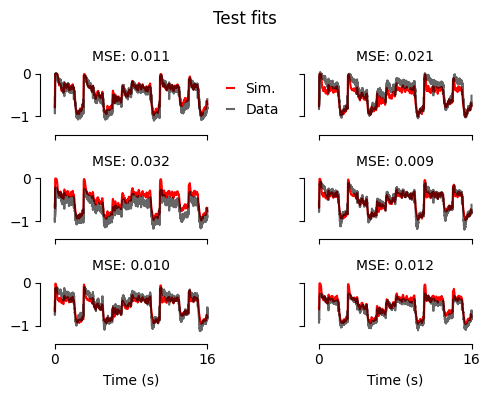

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(5, 4), sharex=True, sharey=True)

for i in range(6):
    # Normalize the final solution
    params = trained_params[i]
    I_dark = (
        params[9]["PR_Phototransduction_G_dark"]
        ** params[7]["PR_Phototransduction_n"]
        * params[5]["PR_Phototransduction_k"]
    )
    # Also sign flip for correct direction
    normed = -1 * final_solns[i] / I_dark  

    axs.flat[i].plot(time, normed, c="r", label="Sim.")
    axs.flat[i].plot(time, responses[i], c="k", alpha=0.6, label="Data")

    axs.flat[i].spines["left"].set_bounds(-1.0, 0)
    axs.flat[i].spines["bottom"].set_bounds(0, 16)

    # Calculate the MSE 
    mse = jnp.sum((normed-responses[i])**2) / normed.size
    axs.flat[i].set_title(f"MSE: {mse:.3f}", fontsize=10)

axs[0, 0].legend(frameon=False, handlelength=0.5, bbox_to_anchor=(1, 1))
axs[-1, 0].set_xlabel("Time (s)")
axs[-1, 1].set_xlabel("Time (s)")

plt.setp(axs, xticks=[0, 16], yticks=[-1.0, 0])
sns.despine(offset=5)

# sns.despine(offset=5)
fig.suptitle("Test fits", fontsize=12)
plt.tight_layout()


Cell number #3 had the lowest test MSE, so these parameters were used for all photoreceptors in future trainings. More exploration of the solution space is ongoing work. 

In [26]:
# Trained solution
best_ind = 3
params = trained_params[best_ind]
I_dark = (
    params[9]["PR_Phototransduction_G_dark"]
    ** params[7]["PR_Phototransduction_n"]
    * params[5]["PR_Phototransduction_k"]
)
test_soln = -1 * final_solns[i] / I_dark  

test_stim = stimuli[best_ind]
test_stim_interp = interp_stim(test_stim)

# Data
test_response = responses[best_ind]

# Init soln
init_soln = simulate(init_params, test_stim_interp)
I_dark_init = (
    params_mouse_cone["PR_Phototransduction_G_dark"] 
    ** params_mouse_cone["PR_Phototransduction_n"]
    * params_mouse_cone["PR_Phototransduction_k"]
)
init_soln = -1 * init_soln / I_dark_init 
init_soln = init_soln[::num_interpolated_points]

Text(0.5, 0, 'Time (s)')

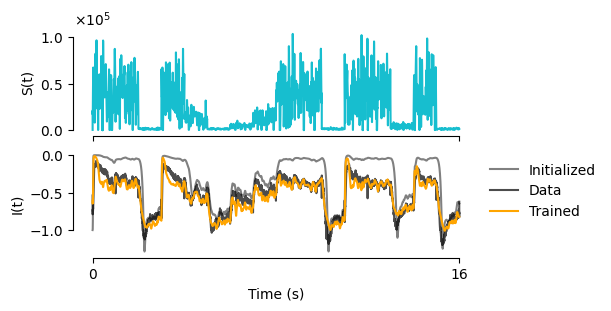

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(6, 3), sharex=True, layout="constrained")
axs[0].plot(time, test_stim, color="tab:cyan")
axs[1].plot(time, init_soln, color="grey", label="Initialized")
axs[1].plot(time, test_response, color="k", alpha=0.7, label="Data")
axs[1].plot(time, test_soln, color="orange", label="Trained")

axs[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axs[0].ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
axs[0].set_ylabel("S(t)")
axs[1].set_ylabel("I(t)")

axs[1].legend(frameon=False, bbox_to_anchor=(1, 1))
sns.despine(offset=1)

axs[0].spines["left"].set_bounds(0, 10**5)
axs[1].spines["left"].set_bounds(-1, 0)
axs[0].spines["bottom"].set_bounds(0, 16)
axs[1].spines["bottom"].set_bounds(0, 16)
# axs[1].set_xlim(0, 16)
axs[1].set_xticks([0, 16])
axs[1].set_xlabel("Time (s)")

In [28]:
# Save the results
with open("../../paper/fig2/notebooks/cascade_final_fit.pkl", "wb") as f:
    pickle.dump(
        {
            "test_stim": test_stim,
            "test_response": test_response,
            "init_normed": init_soln,
            "trained_normed": test_soln 
        },
        f
    )